# Lewis et al. 2015

[Lewis, M. M., Du, G., Lee, E. Y., Nasralah, Z., Sterling, N. W., Zhang, L., ... & Huang, X. (2016). The pattern of gray matter atrophy in Parkinson’s disease differs in cortical and subcortical regions. Journal of neurology, 263(1), 68-75.](https://link.springer.com/article/10.1007/s00415-015-7929-7)

## Demographics

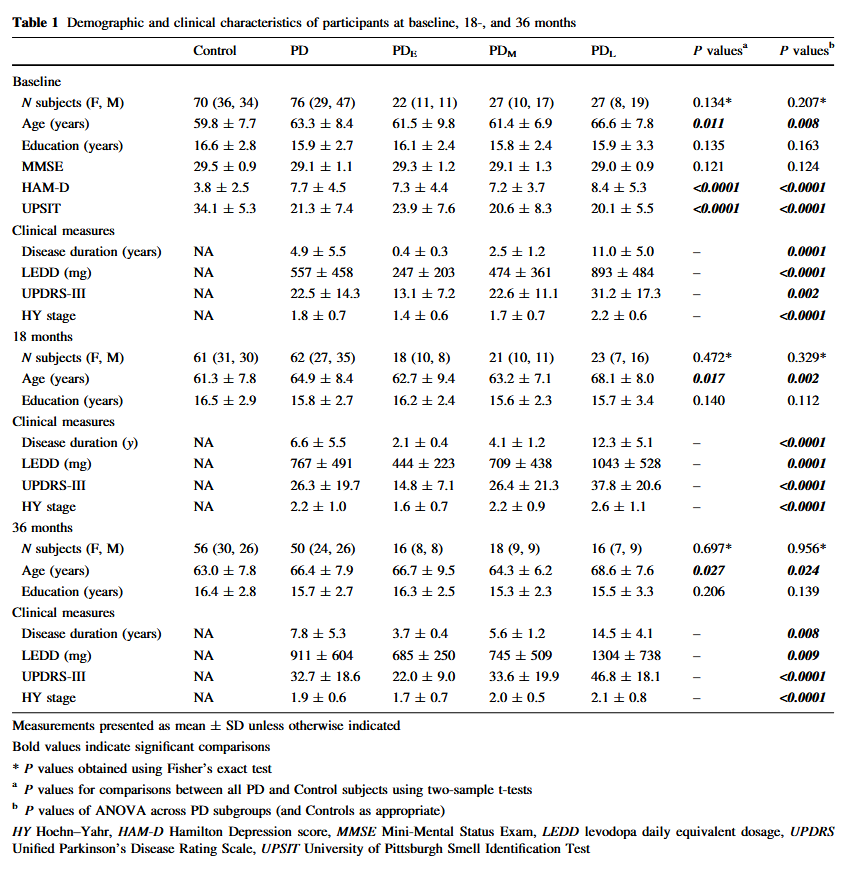

## Results

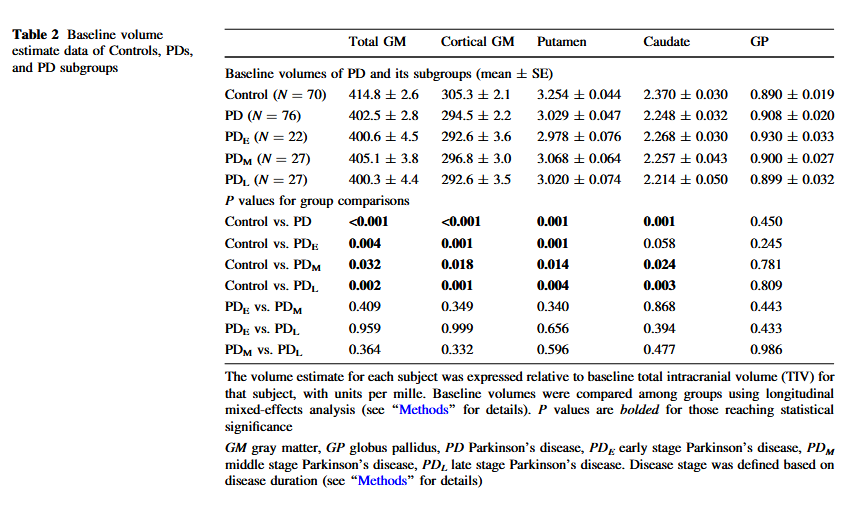

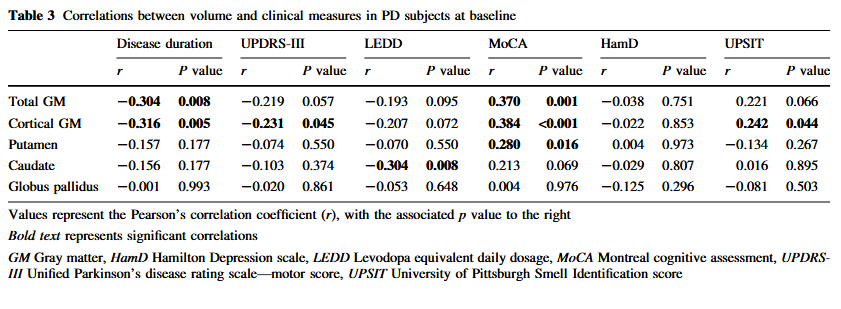

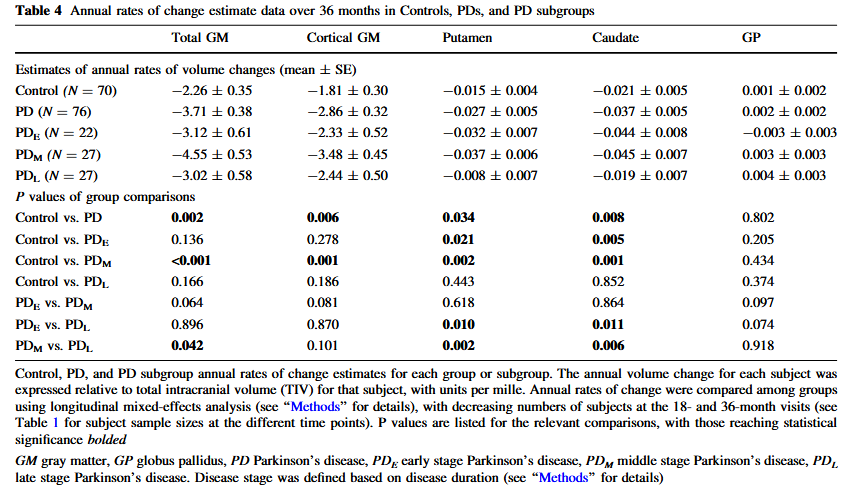

## Consistency

In [21]:
import pandas as pd
from pathlib import Path
from IPython.display import Image

anonymizer = True

root_dir = Path.cwd().parent.parent.parent.parent.resolve()
# root_dir = Path.cwd() / "freesurfer-fuzzy"

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
print(f"Using NPV dir: {anondir(npv_dir)}")
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Lewis_2015"
# data_dir = root_dir / "papers_data" / "parkinson" / "Lewis_2015"
assert data_dir.exists(), f"Data dir does not exist: {anondir(data_dir)}"
print(f"Using data dir: {anondir(data_dir)}")
figure_dir = root_dir / "figures"
figure_dir.mkdir(parents=True, exist_ok=True)
assert figure_dir.exists(), f"Figure dir does not exist: {anondir(figure_dir)}"
print(f"Using figure dir: {anondir(figure_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Lewis_2015
Using figure dir: <living-park>/figures


In [22]:
def show_figure(fig, filename, height=1200, width=1000):
    fig.show()
    fig.write_image(figure_dir / filename, height=height, width=width)
    display(Image(figure_dir / filename))

### Load NPV maps

In [23]:
npv_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume_bilateral.csv"
)
npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_bilateral_longitudinal.csv"
)

### Formula

In [24]:
import numpy as np
import scipy.stats


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n - 2) / (n - 1)) * npv

In [25]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [26]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, title, group=None):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
    ]
    columns = columns + [group] if group else columns
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color=group)
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color=group,
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

## Results

### Table 2 - Group differences

In [27]:
df = pd.read_csv(data_dir / "table_2a.csv")
columns_mapping = {
    "Total GM Mean": "TotalGrayVol_Mean",
    "Total GM SE": "TotalGrayVol_SE",
    "Cortical GM Mean": "CortexVol_Mean",
    "Cortical GM SE": "CortexVol_SE",
    "Putamen Mean": "Putamen_Mean",
    "Putamen SE": "Putamen_SE",
    "Caudate Mean": "Caudate_Mean",
    "Caudate SE": "Caudate_SE",
    "GP Mean": "Pallidum_Mean",
    "GP SE": "Pallidum_SE",
}
df.rename(columns=columns_mapping, inplace=True)
df = df.melt(id_vars=["Group", "N"], var_name="region_stat", value_name="value")
df["region"] = df["region_stat"].str.split("_").str[0]
df["stat"] = df["region_stat"].str.split("_").str[1]
df.drop(columns=["region_stat"], inplace=True)
df = df.pivot_table(
    index=["Group", "N", "region"], columns="stat", values="value"
).reset_index()
df["std"] = df["SE"] * np.sqrt(df["N"])
df["sample_size"] = df["N"]
df.rename(
    columns={"Group": "group", "N": "n", "Mean": "mean", "SE": "se"}, inplace=True
)

In [28]:
df_p = pd.read_csv(data_dir / "table_2b.csv")
region_map = {
    "Total GM": "TotalGrayVol",
    "Cortical GM": "CortexVol",
    "Caudate": "Caudate",
    "Putamen": "Putamen",
    "GP": "Pallidum",
}
df_p = df_p.melt(id_vars=["Comparison"], var_name="metric", value_name="p_value")
df_p["region"] = df_p["metric"].str.split("P-value").str[0]
df_p["region"] = df_p["region"].apply(lambda x: region_map[x.strip()])
df_p[["group1", "group2"]] = df_p["Comparison"].str.split(" vs. ", expand=True)
df_p.drop(columns=["metric"], inplace=True)
df_p.rename(columns={"Comparison": "comparison"}, inplace=True)
df_p = pd.merge(df, df_p, left_on=["region", "group"], right_on=["region", "group1"])
df_p = pd.merge(df, df_p, left_on=["region", "group"], right_on=["region", "group2"])
df_p["t"] = (df_p["mean_x"] - df_p["mean_y"]) / np.sqrt(
    (df_p["se_x"] ** 2 + df_p["se_y"] ** 2)
)
df_p["significant"] = df_p["p_value"] < 0.05

df = pd.merge(
    df_p,
    npv_subcortical_volume[npv_subcortical_volume.region.isin(df_p.region)],
    on="region",
    how="outer",
)
df["test"] = "T"
df["sample_size"] = df["n_x"] + df["n_y"]
df["alpha"] = 0.05
df["std_t"] = df["npv"]
df["std_p"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv"])
df["std_p_low"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv_CI_high"])
df["proba_significant"] = flip_proba_beta(df["p_value"], df["std_p"])

metric_map = {"TotalGrayVol": "volume", 
              "CortexVol": "cortical volume",
              "Caudate": "subcortical volume",
              "Putamen": "subcortical volume",
              "Pallidum": "subcortical volume"}
df["metric"] = df["region"].apply(lambda x: metric_map[x.strip()])
df["study"] = "cross-sectional"
df_t = df.copy()

In [29]:
plot_dumbbell(
    df_t, title="Comparisons of subcortical volumes at baseline", group="comparison"
)

### Table 3 - Partial correlation

In [30]:
import numpy as np

df = pd.read_csv(data_dir / "table_3.csv")
df = df.melt(id_vars=["region"], var_name="stat", value_name="value")
df_r = df[df["stat"].str.contains(" r")].copy()
df_p = df[df["stat"].str.contains(" P-value")].copy()
df_r["clinical_measure"] = df_r["stat"].str.split(" r", expand=True)[0]
df_r.rename(columns={"value": "r"}, inplace=True)
df_p["clinical_measure"] = df_p["stat"].str.split(" P-value", expand=True)[0]
df_p.rename(columns={"value": "p"}, inplace=True)
df_p.drop(columns=["stat"], inplace=True)
df_r.drop(columns=["stat"], inplace=True)
df = pd.merge(df_r, df_p, on=["region", "clinical_measure"])
df = df[["region", "clinical_measure", "r", "p"]]
df = pd.merge(df, npv_subcortical_volume, on=["region"])
df.rename(columns={"p": "p_value"}, inplace=True)

df["test"] = "R"
df["sample_size"] = df["n"]
df["alpha"] = 0.05
df["std_r"] = std_r(df["r"], df["n"], df["npv"])
df["std_p"] = std_p_r(df["r"], df["n"], df["npv"])
df["std_p_low"] = std_p_r(df["r"], df["n"], df["npv_CI_low"])
df["std_p_high"] = std_p_r(df["r"], df["n"], df["npv_CI_high"])
df["proba_significant"] = flip_proba_beta(df["p_value"], df["std_p"])
df["significant"] = df["p_value"] < 0.05
metric_map = {"TotalGrayVol": "volume", 
              "CortexVol": "cortical volume",
              "Caudate": "subcortical volume",
              "Putamen": "subcortical volume",
              "Pallidum": "subcortical volume"}
df["metric"] = df["region"].apply(lambda x: metric_map[x.strip()])
df["study"] = "cross-sectional"
df_r = df.copy()

In [31]:
plot_dumbbell(
    df_r,
    title="Correlation between subcortical volumes and clinical measures",
    group="clinical_measure",
)

### Table 4 - Group differences longitudinally

In [32]:
import numpy as np

df = pd.read_csv(data_dir / "table_4a.csv")
columns_mapping = {
    "Total GM Mean": "TotalGrayVol_Mean",
    "Total GM SE": "TotalGrayVol_SE",
    "Cortical GM Mean": "CortexVol_Mean",
    "Cortical GM SE": "CortexVol_SE",
    "Putamen Mean": "Putamen_Mean",
    "Putamen SE": "Putamen_SE",
    "Caudate Mean": "Caudate_Mean",
    "Caudate SE": "Caudate_SE",
    "GP Mean": "Pallidum_Mean",
    "GP SE": "Pallidum_SE",
}
df.rename(columns=columns_mapping, inplace=True)
df = df.melt(id_vars=["Group", "N"], var_name="region_stat", value_name="value")
df["region"] = df["region_stat"].str.split("_").str[0]
df["stat"] = df["region_stat"].str.split("_").str[1]
df.drop(columns=["region_stat"], inplace=True)
df = df.pivot_table(
    index=["Group", "N", "region"], columns="stat", values="value"
).reset_index()
df["std"] = df["SE"] * np.sqrt(df["N"])
df["sample_size"] = df["N"]
df.rename(
    columns={"Group": "group", "N": "n", "Mean": "mean", "SE": "se"}, inplace=True
)

In [33]:
df_p = pd.read_csv(data_dir / "table_4b.csv")
region_map = {
    "Total GM": "TotalGrayVol",
    "Cortical GM": "CortexVol",
    "Caudate": "Caudate",
    "Putamen": "Putamen",
    "GP": "Pallidum",
}
df_p = df_p.melt(id_vars=["Comparison"], var_name="metric", value_name="p_value")
df_p["region"] = df_p["metric"].str.split("P-value").str[0]
df_p["region"] = df_p["region"].apply(lambda x: region_map[x.strip()])
df_p[["group1", "group2"]] = df_p["Comparison"].str.split(" vs. ", expand=True)
df_p.drop(columns=["metric"], inplace=True)
df_p.rename(columns={"Comparison": "comparison"}, inplace=True)
df_p = pd.merge(df, df_p, left_on=["region", "group"], right_on=["region", "group1"])
df_p = pd.merge(df, df_p, left_on=["region", "group"], right_on=["region", "group2"])
df_p["t"] = (df_p["mean_x"] - df_p["mean_y"]) / np.sqrt(
    (df_p["se_x"] ** 2 + df_p["se_y"] ** 2)
)

df = pd.merge(
    df_p,
    npv_subcortical_volume_long[npv_subcortical_volume_long.region.isin(df_p.region)],
    on="region",
    how="outer",
)
df["test"] = "T"
df["alpha"] = 0.05
df["sample_size"] = df["n_x"] + df["n_y"]
df["std_t"] = df["npv"]
df["std_p"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv"])
df["std_p_low"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_t(df["t"], df["n_x"] + df["n_y"] - 2, df["npv_CI_high"])
df["proba_significant"] = flip_proba_beta(df["p_value"], df["std_p"])
df["significant"] = df["p_value"] < 0.05
metric_map = {"TotalGrayVol": "volume", 
              "CortexVol": "cortical volume",
              "Caudate": "subcortical volume",
              "Putamen": "subcortical volume",
              "Pallidum": "subcortical volume"}
df["metric"] = df["region"].apply(lambda x: metric_map[x.strip()])
df["study"] = "longitudinal"
df_t_long = df.copy()

In [34]:
plot_dumbbell(
    df_t_long,
    title="Comparisons of subcortical volumes longitudinally",
    group="comparison",
)

In [35]:
df = pd.concat([df_t, df_r, df_t_long], ignore_index=True)
# Assert dataframe contains "proba_significant" and "significant" columns
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)